### Ritajit Majumdar
Quantum Enablement and Engineering Team @IBM Quantum

### Running a circuit with Qiskit primitives

#### Hello World: Creating an entangled state

$|\psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$

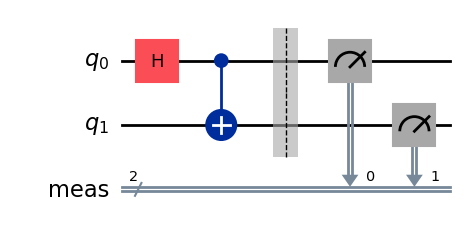

In [1]:
from qiskit import QuantumCircuit, QuantumRegister

# Initialize the qubits
qubits = QuantumRegister(2, name="q")

# Create the circuit
circuit = QuantumCircuit(qubits)

# Unpack the qubits
q0, q1 = qubits

# Add the Hadamard and CNOT gates to the circuit
circuit.h(q0)
circuit.cx(q0, q1)
circuit.measure_all()

circuit.draw("mpl")

#### Obtaining probability distribution with Sampler

When we measure the state $|\psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$, we obtain $|00\rangle$ with probability $|\frac{1}{\sqrt{2}}|^2 = \frac{1}{2}$ or $|11\rangle$ with probability $|\frac{1}{\sqrt{2}}|^2 = \frac{1}{2}$

In [2]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2

In [3]:
sampler = SamplerV2(backend=AerSimulator())
sampler.options.default_shots = 10000

In [4]:
job = sampler.run([circuit])

In [5]:
result = job.result()[0]
counts = result.data.meas.get_counts()

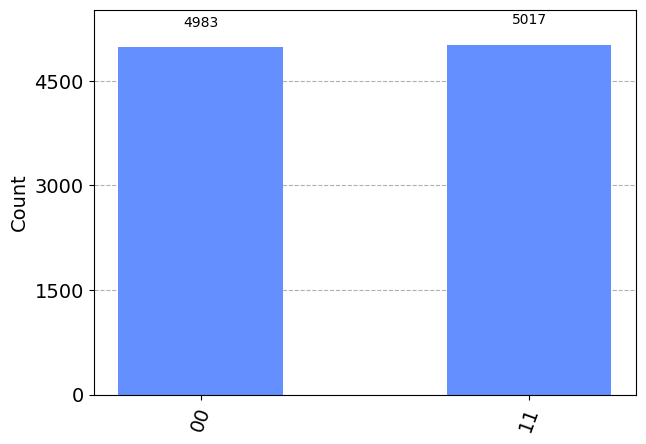

In [6]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

#### Obtaining expectation value with Estimator

Take a quantum state $|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Expectation value always corresponds to some observable (a hermitian operator). For example, expectation value of $Z$ is <br><br>$\langle \psi|Z|\psi \rangle \Rightarrow \frac{1}{\sqrt{2}}(\langle 0|Z|0 \rangle + \langle 1|Z|1 \rangle)$.
<br><br>Recall that $Z|0\rangle = |0\rangle$ and $Z|1\rangle = -|1\rangle$.
<br><br>Therefore, $\langle 0|Z|0 \rangle = \langle 0|0 \rangle = 1$, and $\langle 1|Z|1 \rangle = -\langle 1|1 \rangle = -1$
<br><br>Hence, $\langle \psi|Z|\psi \rangle = \frac{1}{\sqrt{2}}(1-1) = 0$

In [7]:
from qiskit.quantum_info import SparsePauliOp

observables = [
    SparsePauliOp('ZZ'),
    SparsePauliOp('ZI'),
    SparsePauliOp('IZ'),
    SparsePauliOp('XX'),
    SparsePauliOp('XI'),
    SparsePauliOp('IX')
]

observables

[SparsePauliOp(['ZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IX'],
               coeffs=[1.+0.j])]

In [8]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=AerSimulator())

In [9]:
job = estimator.run([(circuit, observables)])

In [10]:
result = job.result()

In [11]:
result[0].data.evs

array([ 1.        , -0.015625  , -0.015625  , -0.03710938,  0.00585938,
        0.00488281])

### Application: Finding the Max-Cut of a graph

In [12]:
import networkx as nx

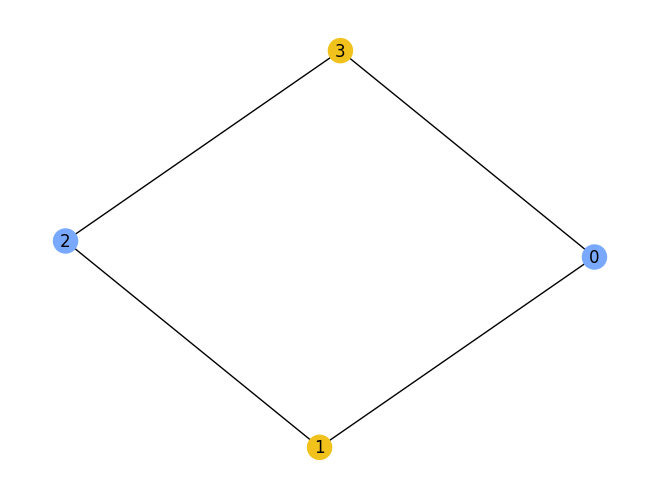

In [13]:
G = nx.Graph()
G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(2,3)
G.add_edge(3,0)

color_map = ['#78a9ff','#f1c21b','#78a9ff','#f1c21b']
nx.draw(G, node_color=color_map, with_labels=True)

#### A brief introduction to QAOA

A QAOA is a variational algorithm where first a trial parameterized circuit, called `ansatz`, is prepared which is initialized, usually, with some random parameters. The circuit is then measured, and the expectation value of some observable is calculated. This entire process is called one *iteration*. This value is passed on to a classical optimizer, which predicts a new set of parameters such that the following iteration is expected to produce a better expectation value. This process is repeated till some convergence criteria is met.

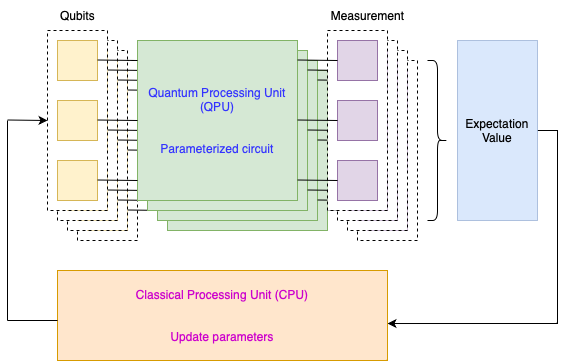

A QAOA circuit is characterized by two unitaries $U(H_P,\gamma)$ and $U(H_M,\beta)$, where $\gamma$ and $\beta$ are parameters. $H_P$ is the Hamltonian whose ground state is the solution of the problem at hand (e.g., vertex cover, max-cut etc.), and $H_M$ is some other Hamiltonian such that $[H_P,H_M] \neq 0$. A depth-p QAOA ansatz is mathematically expressed as:

<center>$|\gamma, \beta \rangle_p = U(H_M,\beta_p)U(H_P,\gamma_p) ... U(H_M,\beta_1)U(H_P,\gamma_1)|\psi_0 \rangle$</center>     

$|\psi_0 \rangle$ being some initial state, often an equal superposition state.

#### Create circuit and observables

In [65]:
from qiskit.circuit import ParameterVector

def create_qaoa_circuit(num_qubits: int, depth: int = 1) -> QuantumCircuit:
    qaoa = QuantumCircuit(num_qubits, name='q')
    qaoa.h(range(num_qubits))

    gamma = ParameterVector('γ',depth)
    beta = ParameterVector('β',depth)

    for d in range(depth):
        # problem Hamiltonian
        for i in range(num_qubits-1):
            qaoa.rzz(gamma[d],i,i+1)
            
        qaoa.rzz(gamma[d],num_qubits-1,0)

        # mixer Hamiltonian
        for i in range(num_qubits):
            qaoa.rx(beta[d],i)
            
        if d != depth-1:
            qaoa.barrier()

    return qaoa

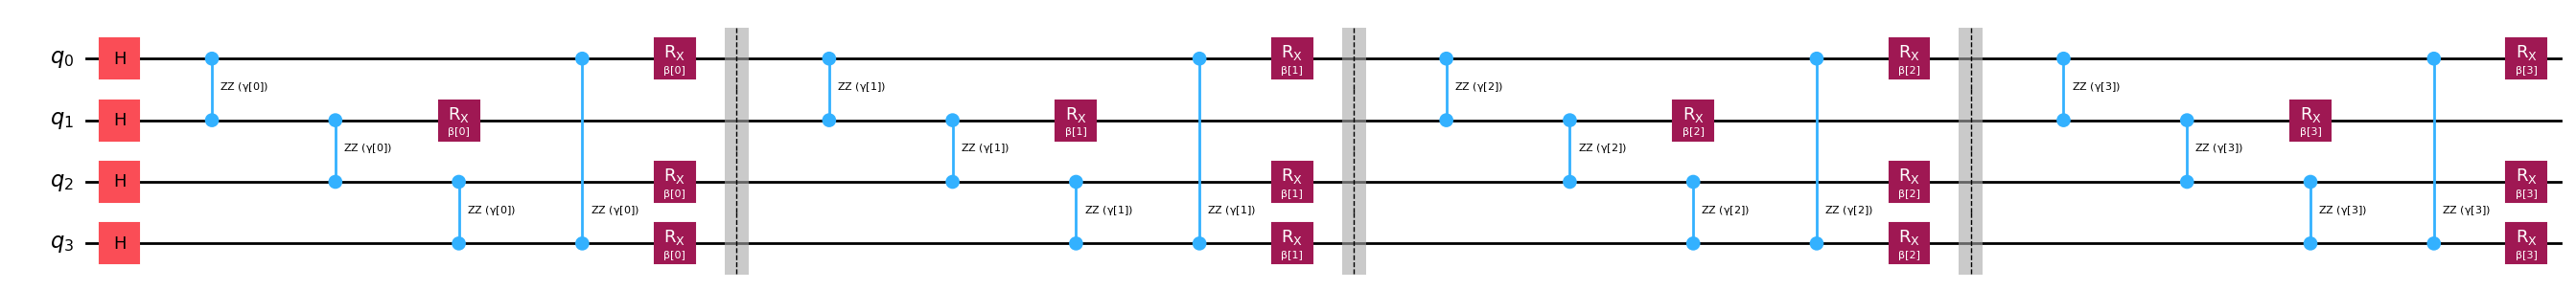

In [78]:
qaoa = create_qaoa_circuit(num_qubits=4,depth=4)
qaoa.draw('mpl',fold=-1)

In [79]:
observables = [
    SparsePauliOp('ZZII'),
    SparsePauliOp('IZZI'),
    SparsePauliOp('IIZZ'),
    SparsePauliOp('ZIIZ')
]

In [80]:
observables

[SparsePauliOp(['ZZII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIIZ'],
               coeffs=[1.+0.j])]

#### Run optimization

In [81]:
init_params = [0]*qaoa.num_parameters
init_params

[0, 0, 0, 0, 0, 0, 0, 0]

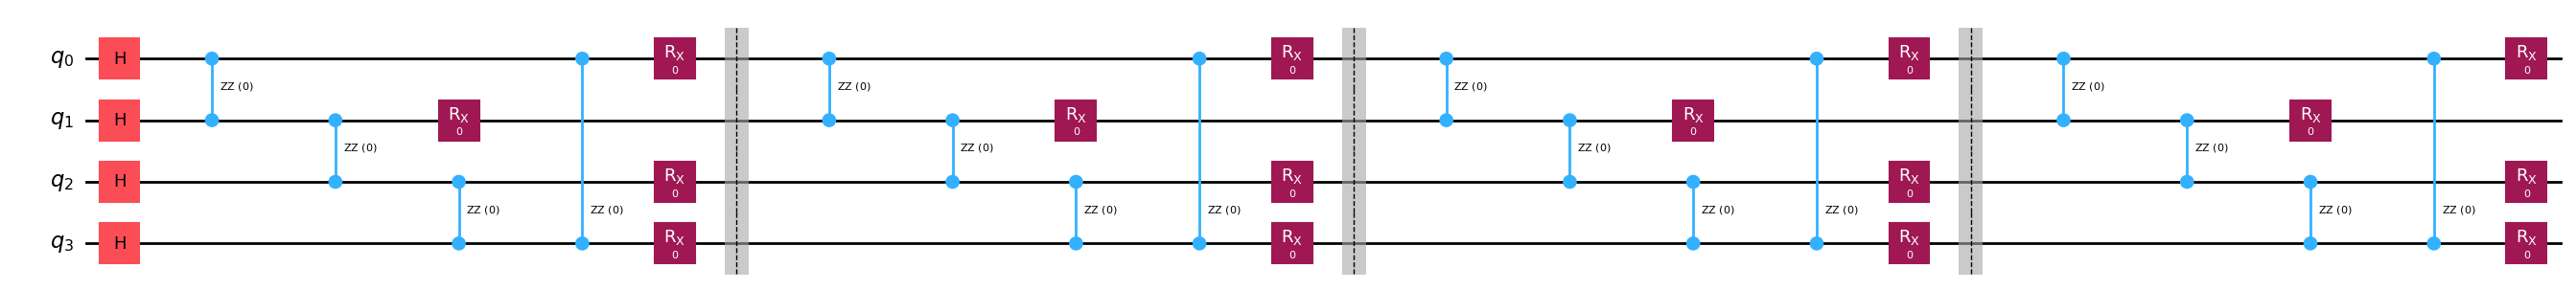

In [82]:
qaoa_params = qaoa.assign_parameters(init_params)
qaoa_params.draw('mpl', fold=-1)

In [83]:
def obtain_expval(params: list, qaoa: QuantumCircuit, observables: list, estimator) -> float:
    # execute the circuit
    job = estimator.run([(qaoa, observables, params)])
    result = job.result()[0]

    # sum up values
    value = sum(result.data.evs)

    return value

In [84]:
from scipy.optimize import minimize

ideal_res = minimize(
    obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="cobyla"
)

In [85]:
ideal_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.998046875
       x: [ 1.138e+00  1.162e+00 -5.662e-01 -1.101e-01 -1.264e+00
           -1.338e+00 -5.884e-01 -6.898e-01]
    nfev: 87
   maxcv: 0.0

In [86]:
ideal_expval = ideal_res.fun

#### Obtain the resulting distribution

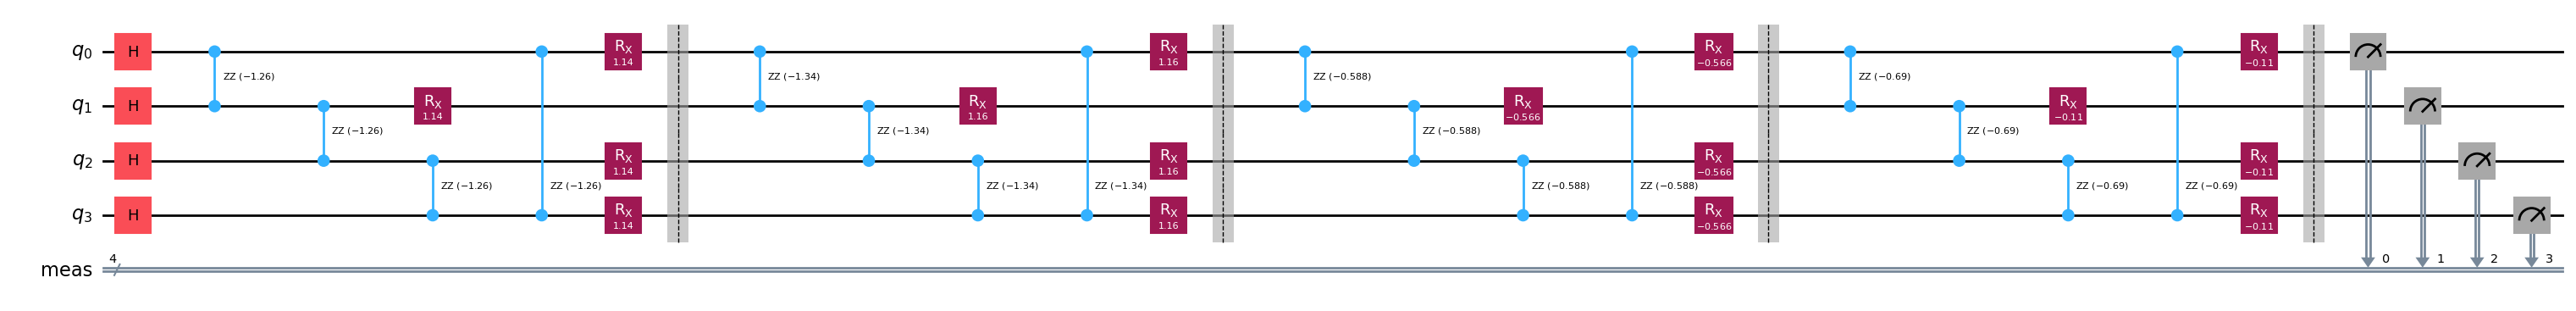

In [87]:
qaoa.assign_parameters(ideal_res.x, inplace=True)
qaoa.measure_all()
qaoa.draw('mpl',fold=-1)

In [88]:
job = sampler.run([qaoa])
result = job.result()[0]
counts = result.data.meas.get_counts()

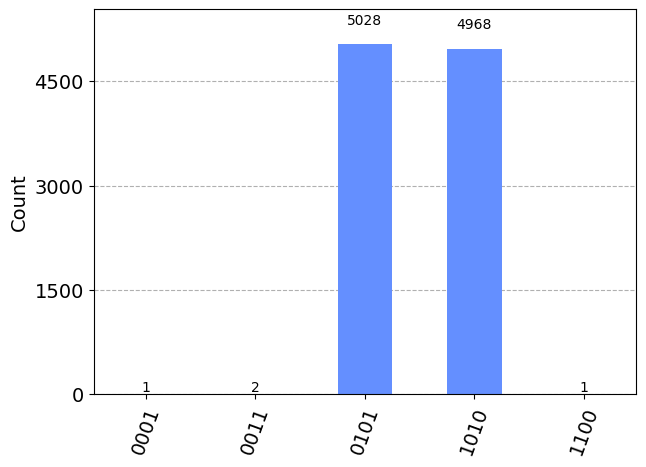

In [89]:
plot_histogram(counts)

### Running on a (fake) backend

In [90]:
from qiskit_ibm_runtime.fake_provider import FakeKolkata

backend = FakeKolkata()

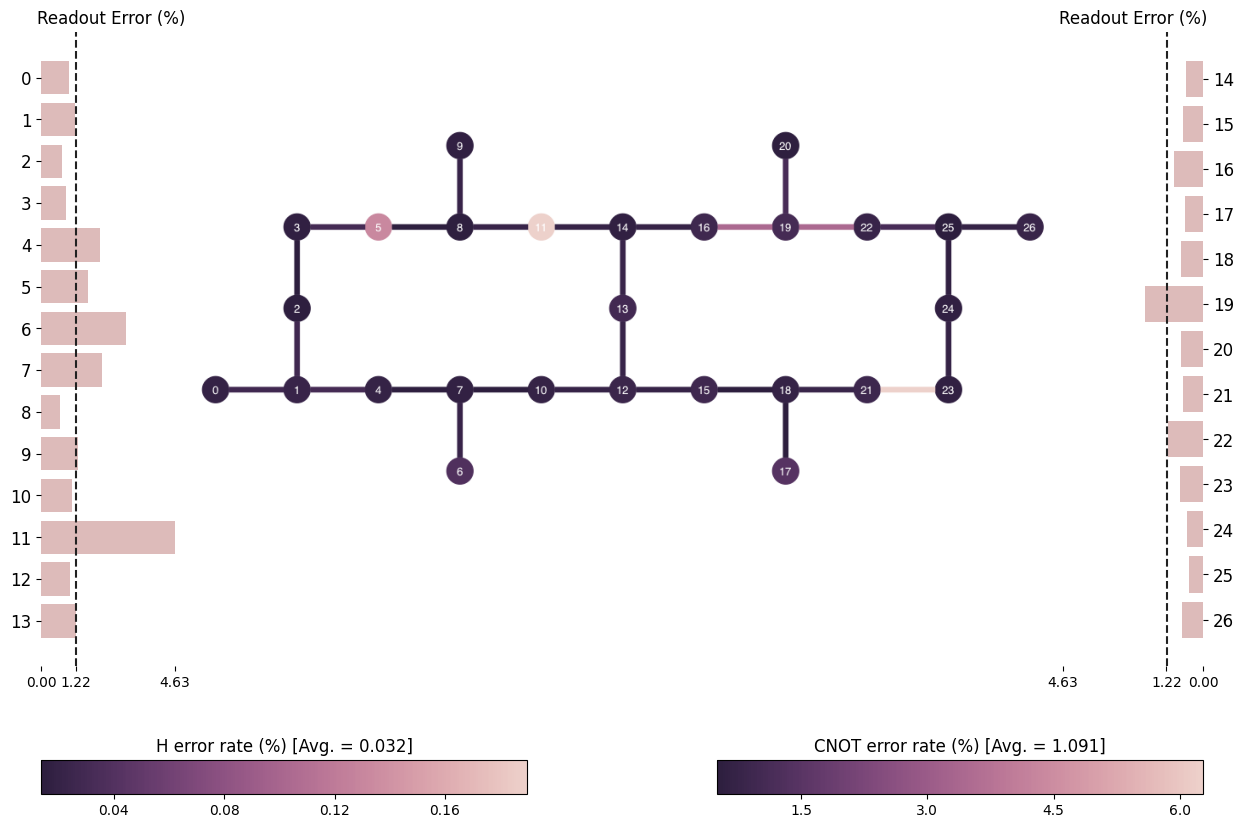

In [91]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, show_title=False)

In [92]:
config = backend.configuration()
print(
    64 * "#",
    "\nConfiguration for: {}, version: {}".format(
        config.backend_name, config.backend_version
    ),
)
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))

################################################################ 
Configuration for: fake_kolkata, version: 1.9.9
  Number of Qubits: 27
  Basis Gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']


#### Transpile circuit

In [93]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, coupling_map=backend.configuration().coupling_map, basis_gates=['x','sx','rz','cx','id','swap'])

In [94]:
trans_circuit = pm.run(qaoa)

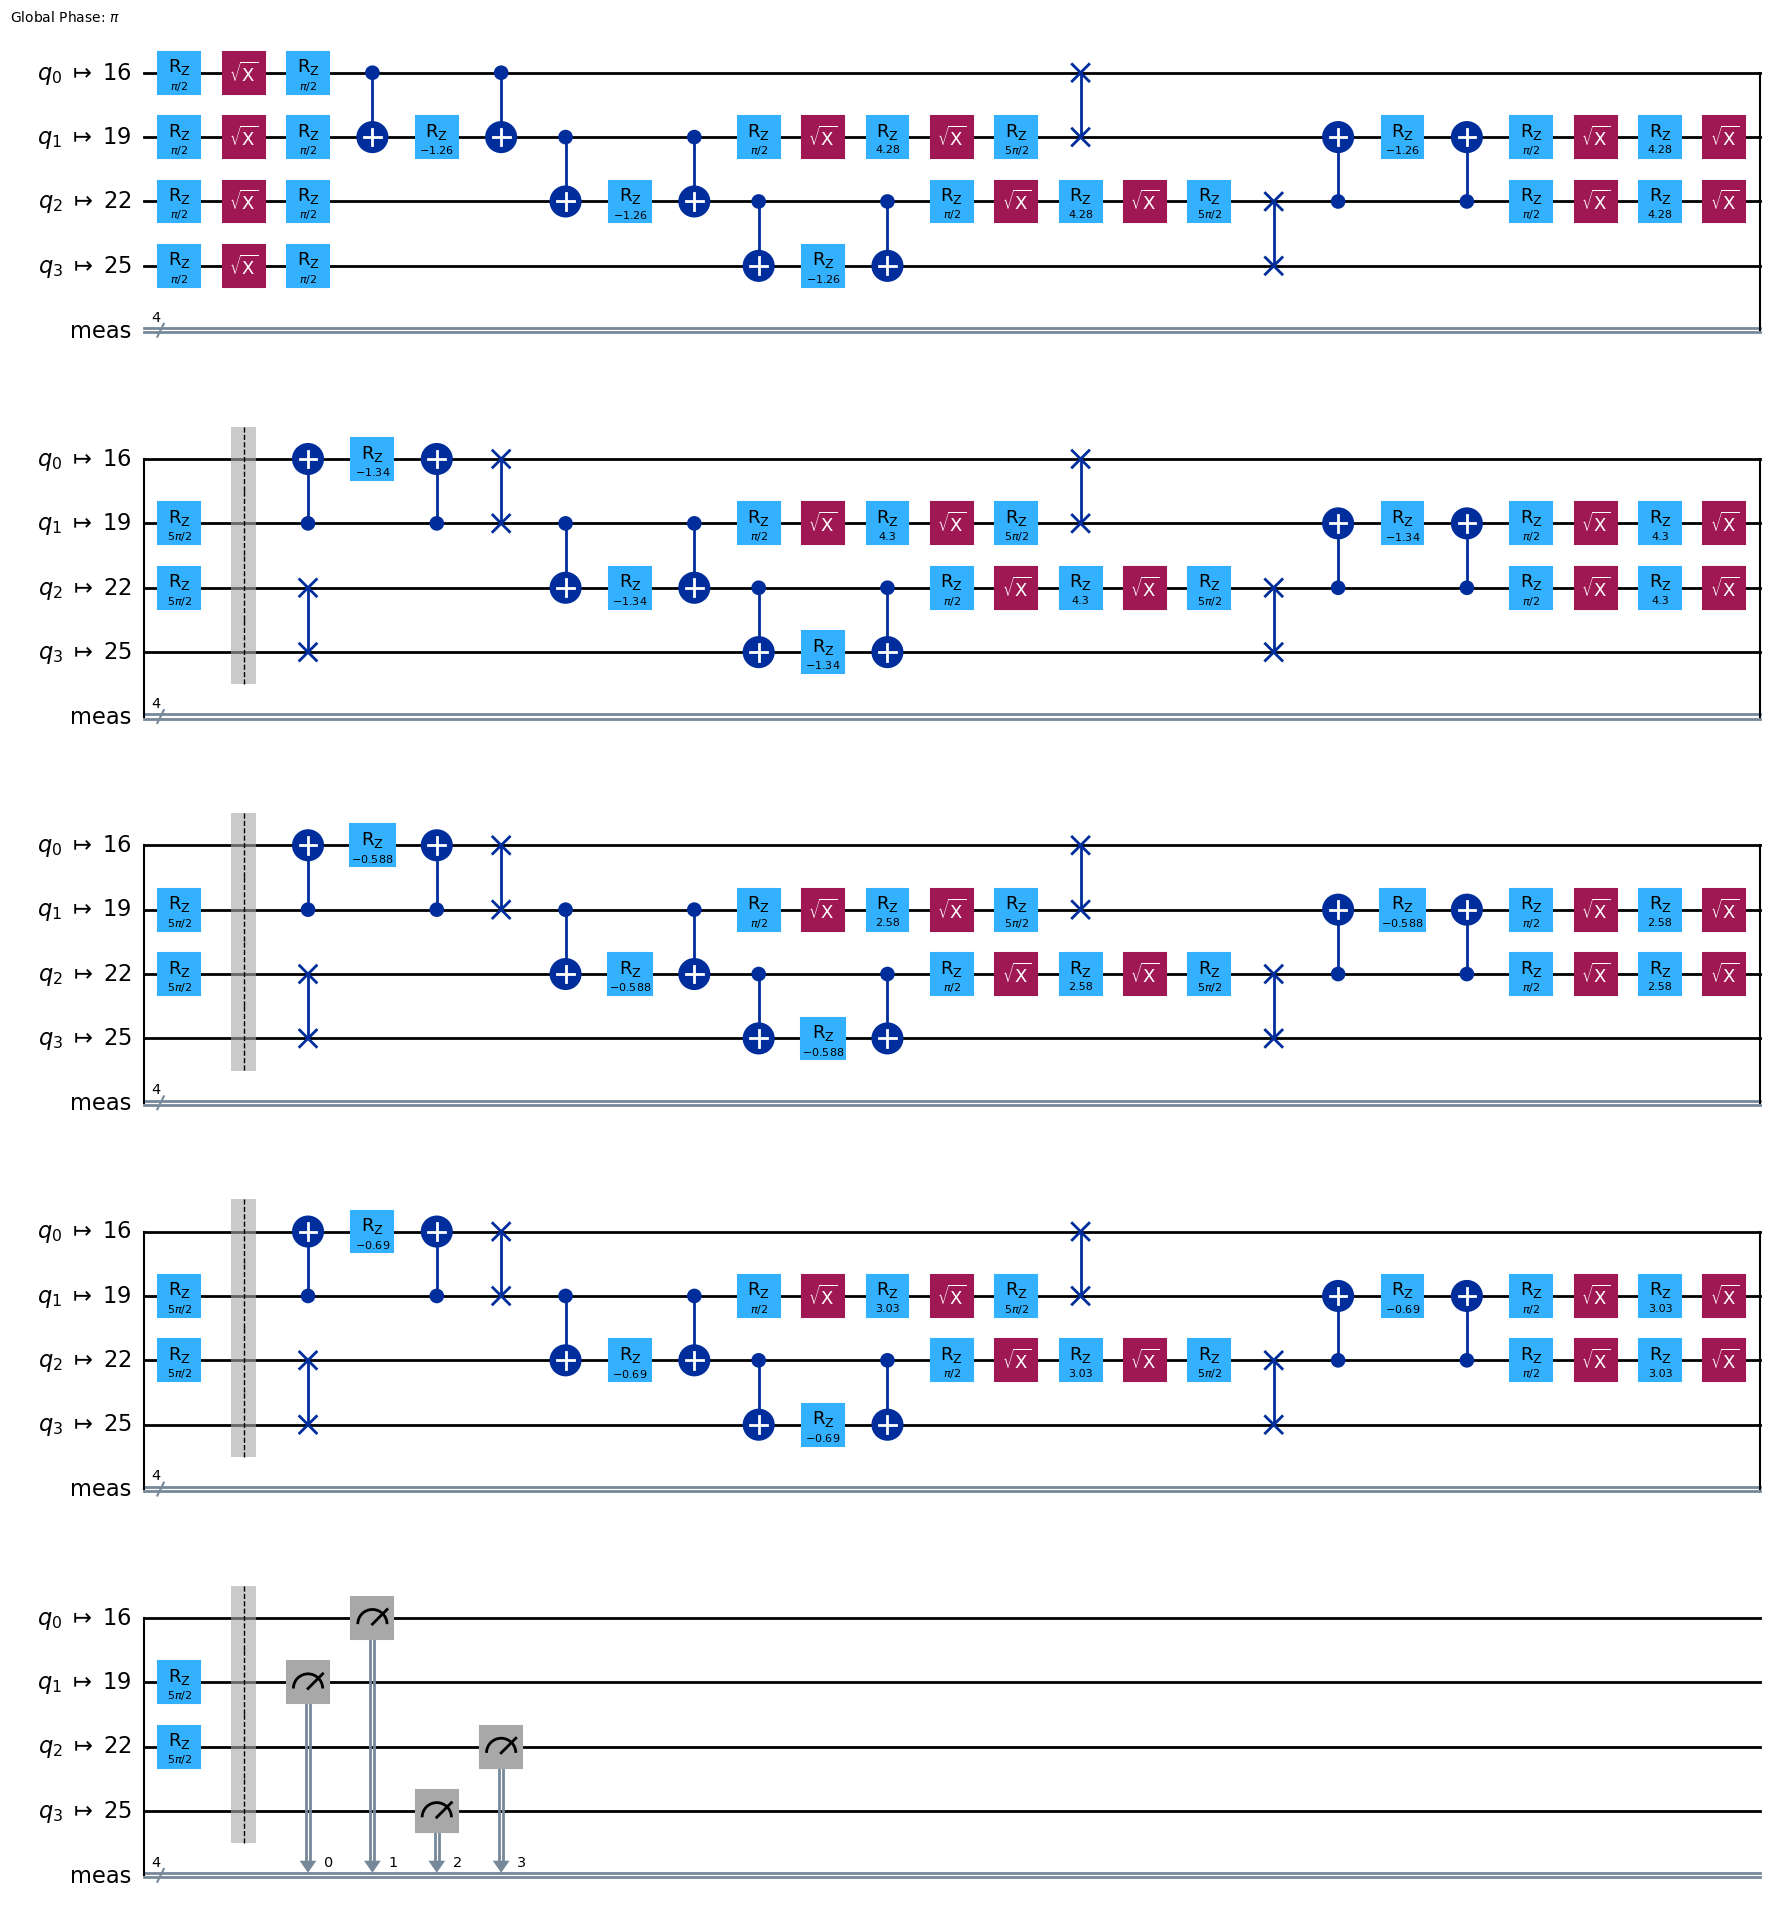

In [95]:
trans_circuit.draw('mpl',idle_wires=False)

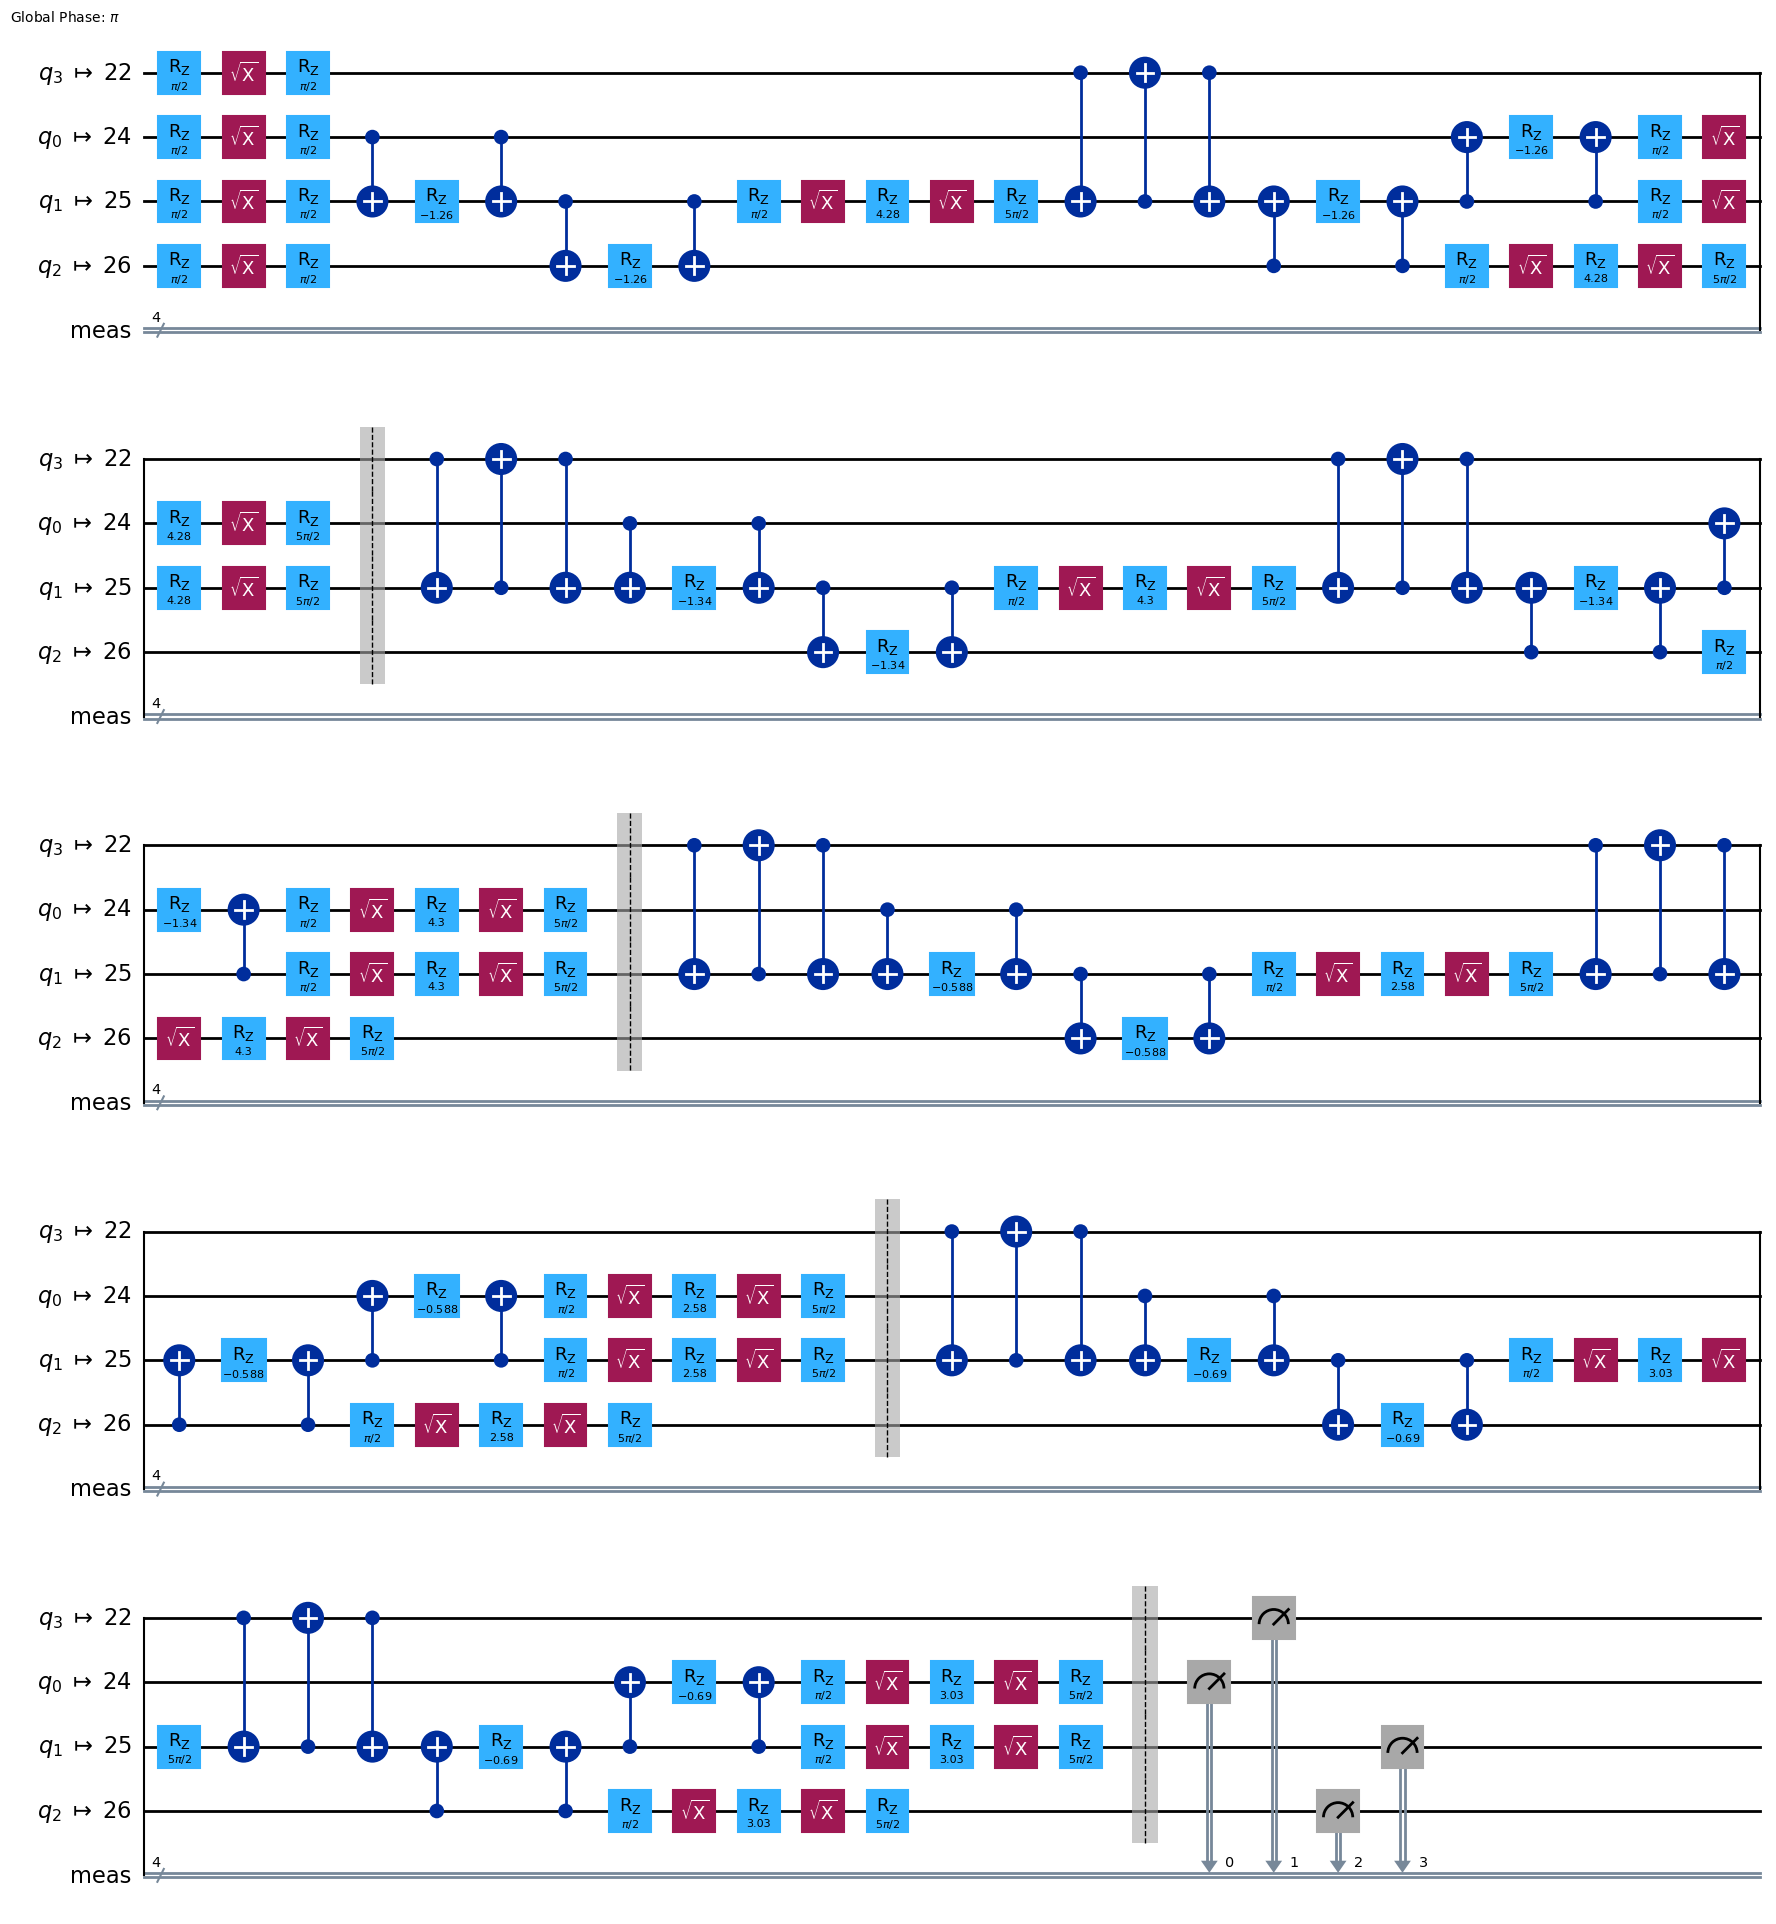

In [96]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
trans_circuit = pm.run(qaoa)
trans_circuit.draw('mpl',idle_wires=False)

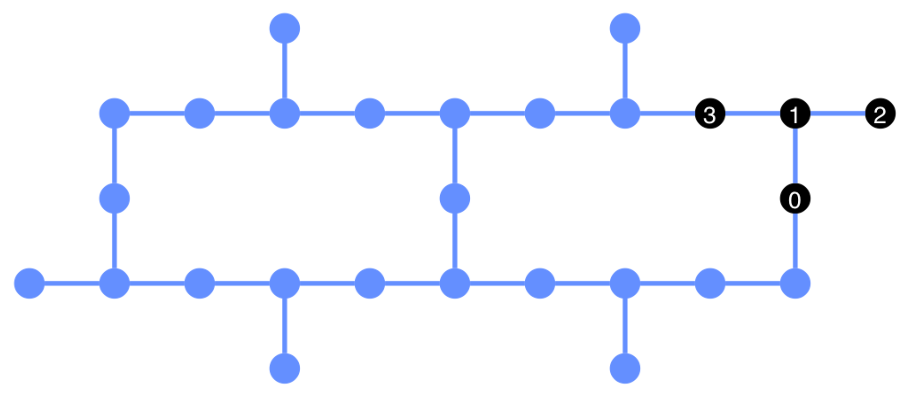

In [97]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(trans_circuit, backend)

#### Execute

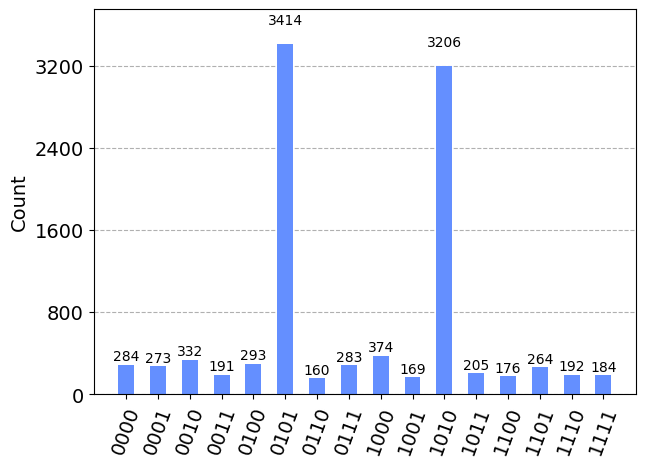

In [98]:
sampler = SamplerV2(backend=FakeKolkata())
sampler.options.default_shots = 10000

job = sampler.run([trans_circuit])
result = job.result()[0]
counts = result.data.meas.get_counts()

plot_histogram(counts)

### Error mitigation: Zero Noise Extrapolation

#### Noisy expectation value

In [99]:
noisy_estimator = EstimatorV2(backend=backend)

In [100]:
isa_observables = [obs.apply_layout(trans_circuit.layout) for obs in observables]
isa_observables

[SparsePauliOp(['ZZIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIIIZIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZIZIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZZIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j])]

In [101]:
noisy_job = noisy_estimator.run([(trans_circuit, isa_observables)])

In [102]:
noisy_result = noisy_job.result()[0]
ns_expvals = noisy_result.data.evs

In [103]:
ns_expvals

array([-0.6171875 , -0.62207031, -0.60302734, -0.60986328])

In [104]:
noisy_expval = sum(ns_expvals)
noisy_expval

-2.4521484375

#### Amplify circuit

In [105]:
from zne.noise_amplification import LocalFoldingAmplifier

amplifier = LocalFoldingAmplifier(gates_to_fold=2)

##### Noise factor 1.2

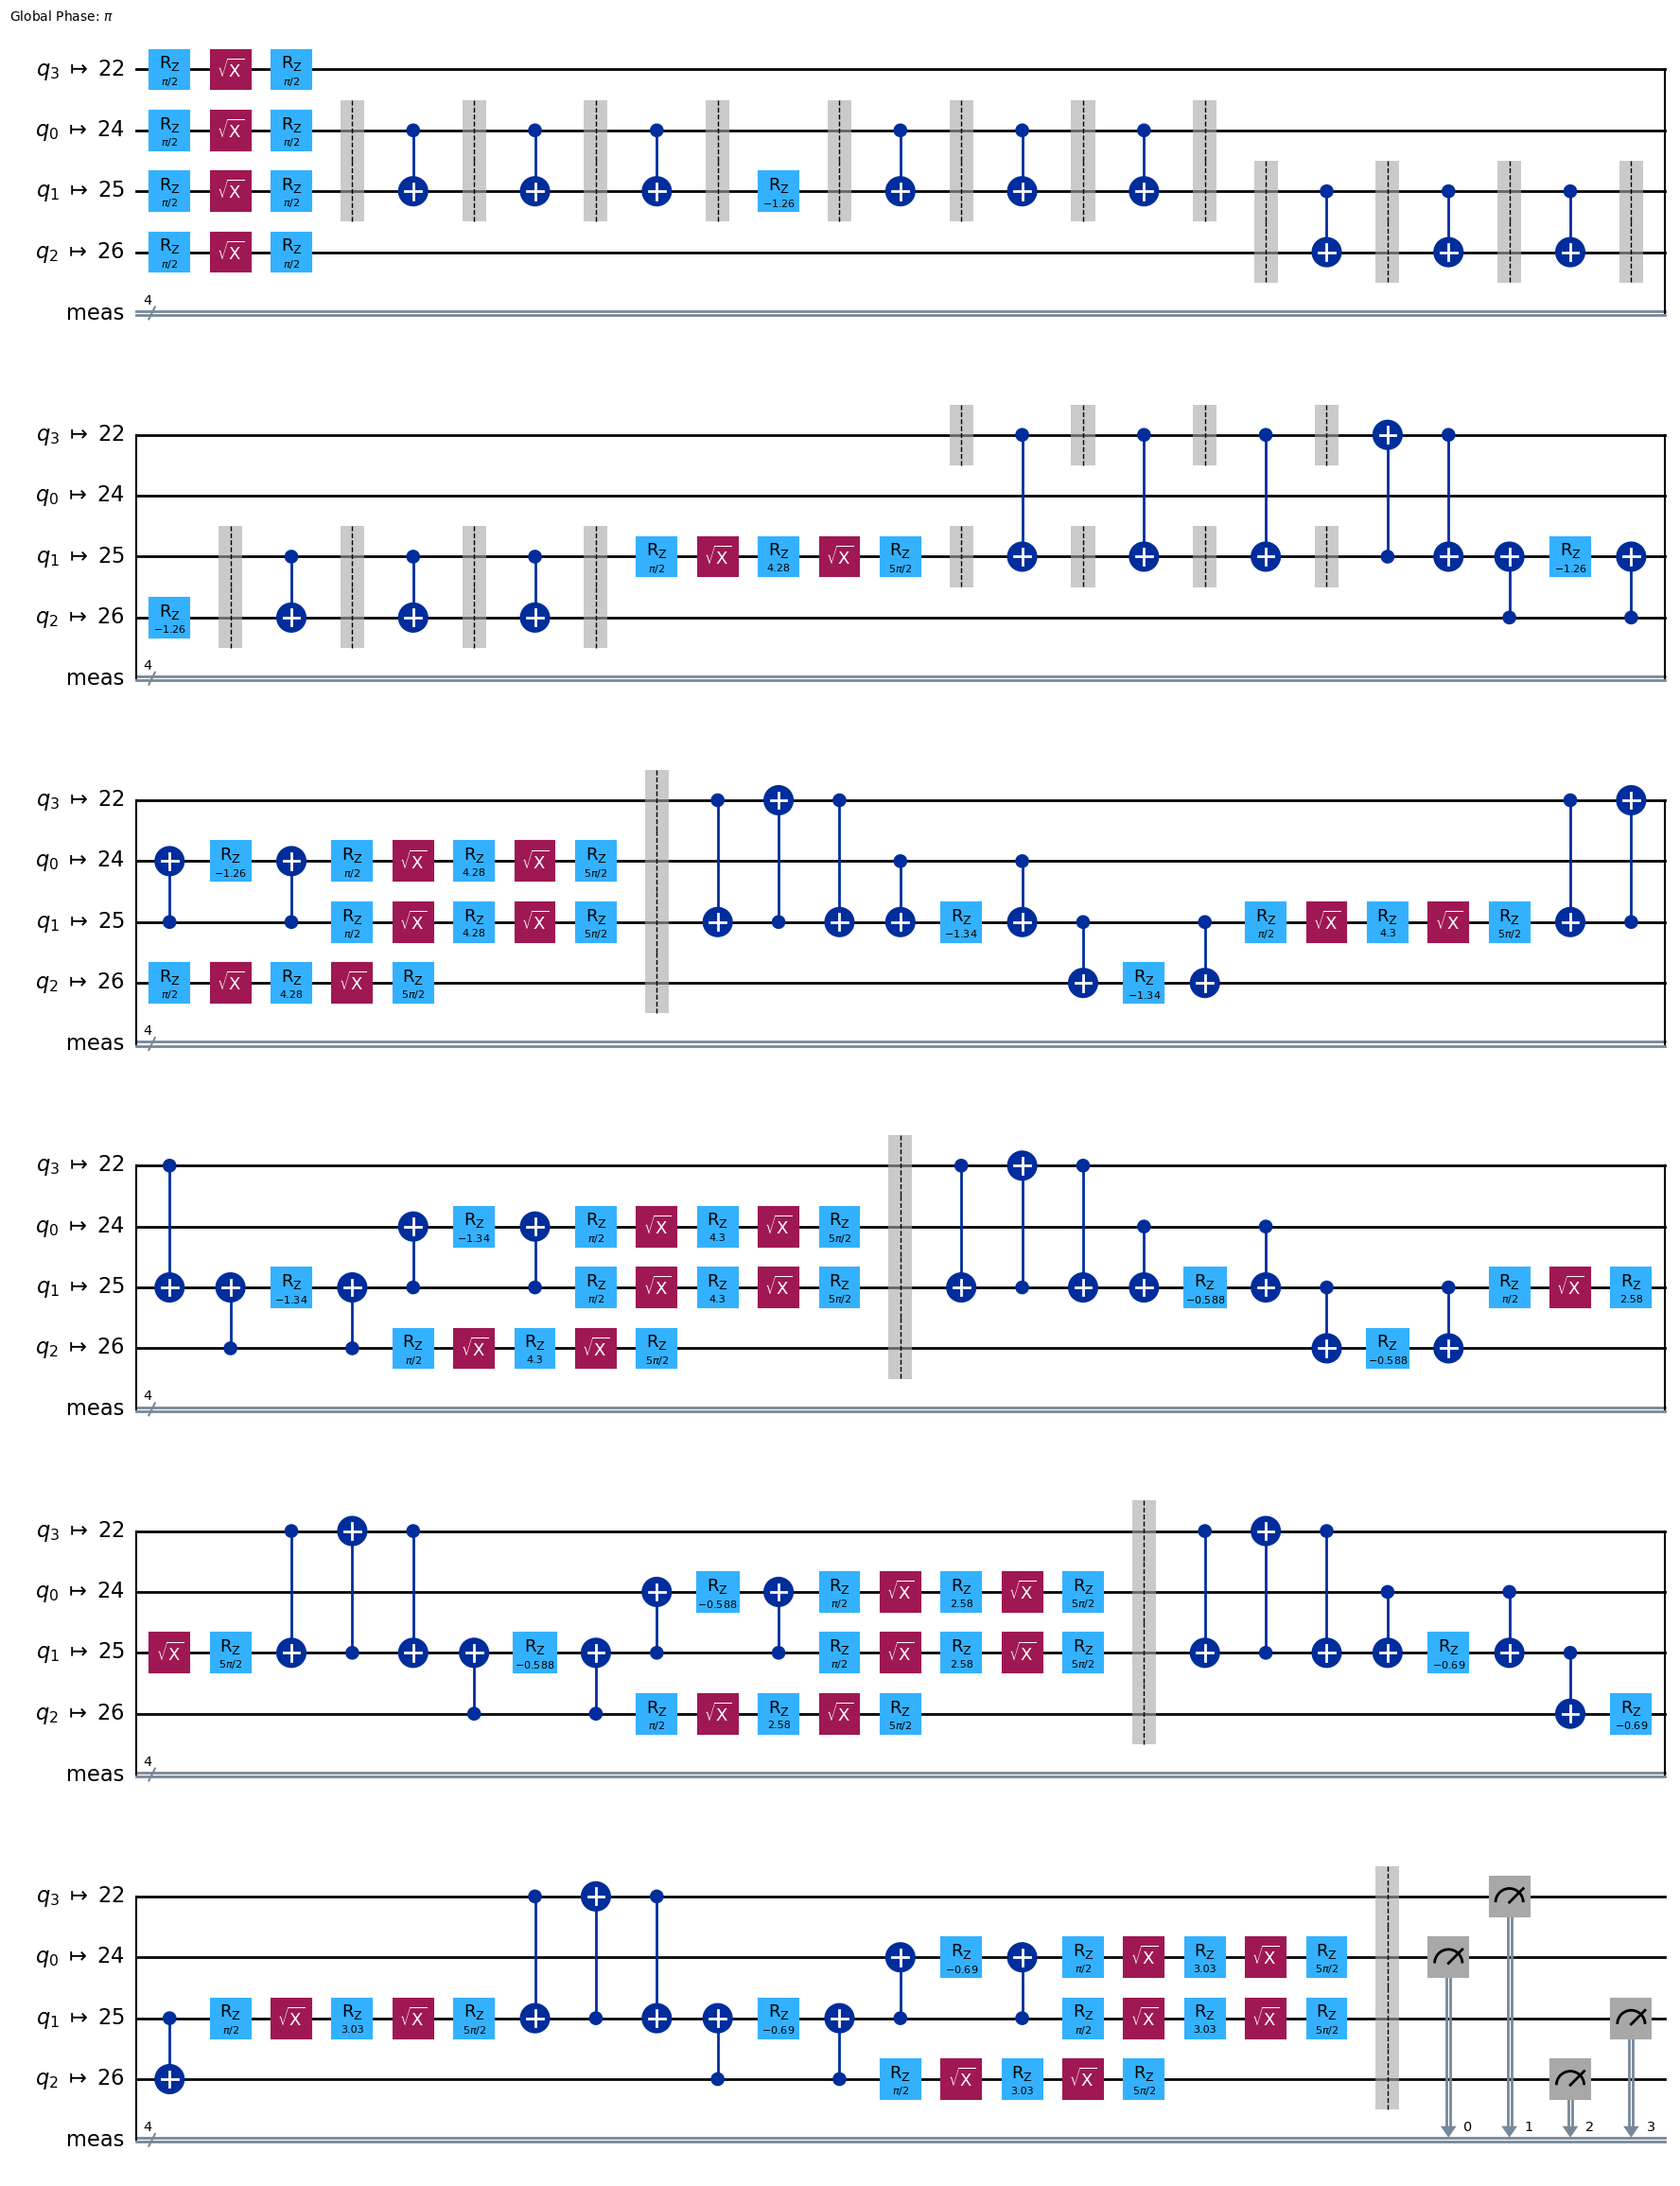

In [106]:
amplified_circuit = amplifier.amplify_circuit_noise(trans_circuit, noise_factor=1.2)
amplified_circuit.draw('mpl', idle_wires=False)

In [107]:
amplified_job = noisy_estimator.run([(amplified_circuit, isa_observables)])

In [108]:
amplified_result = amplified_job.result()[0]
amplified_expval = sum(amplified_result.data.evs)

In [109]:
amplified_expval

-2.2451171875

##### Noise factor 1.4

/Users/ritajit/opt/anaconda3/envs/qeet-main/lib/python3.11/site-packages/zne/noise_amplification/folding_amplifier/folding_amplifier.py:173: UserWarning: Rounding of noise factor: Foldings are performed with noise factor 1.42 instead of specified noise factor 1.40 which amounts to a relative error of 1.08%.
  warn(


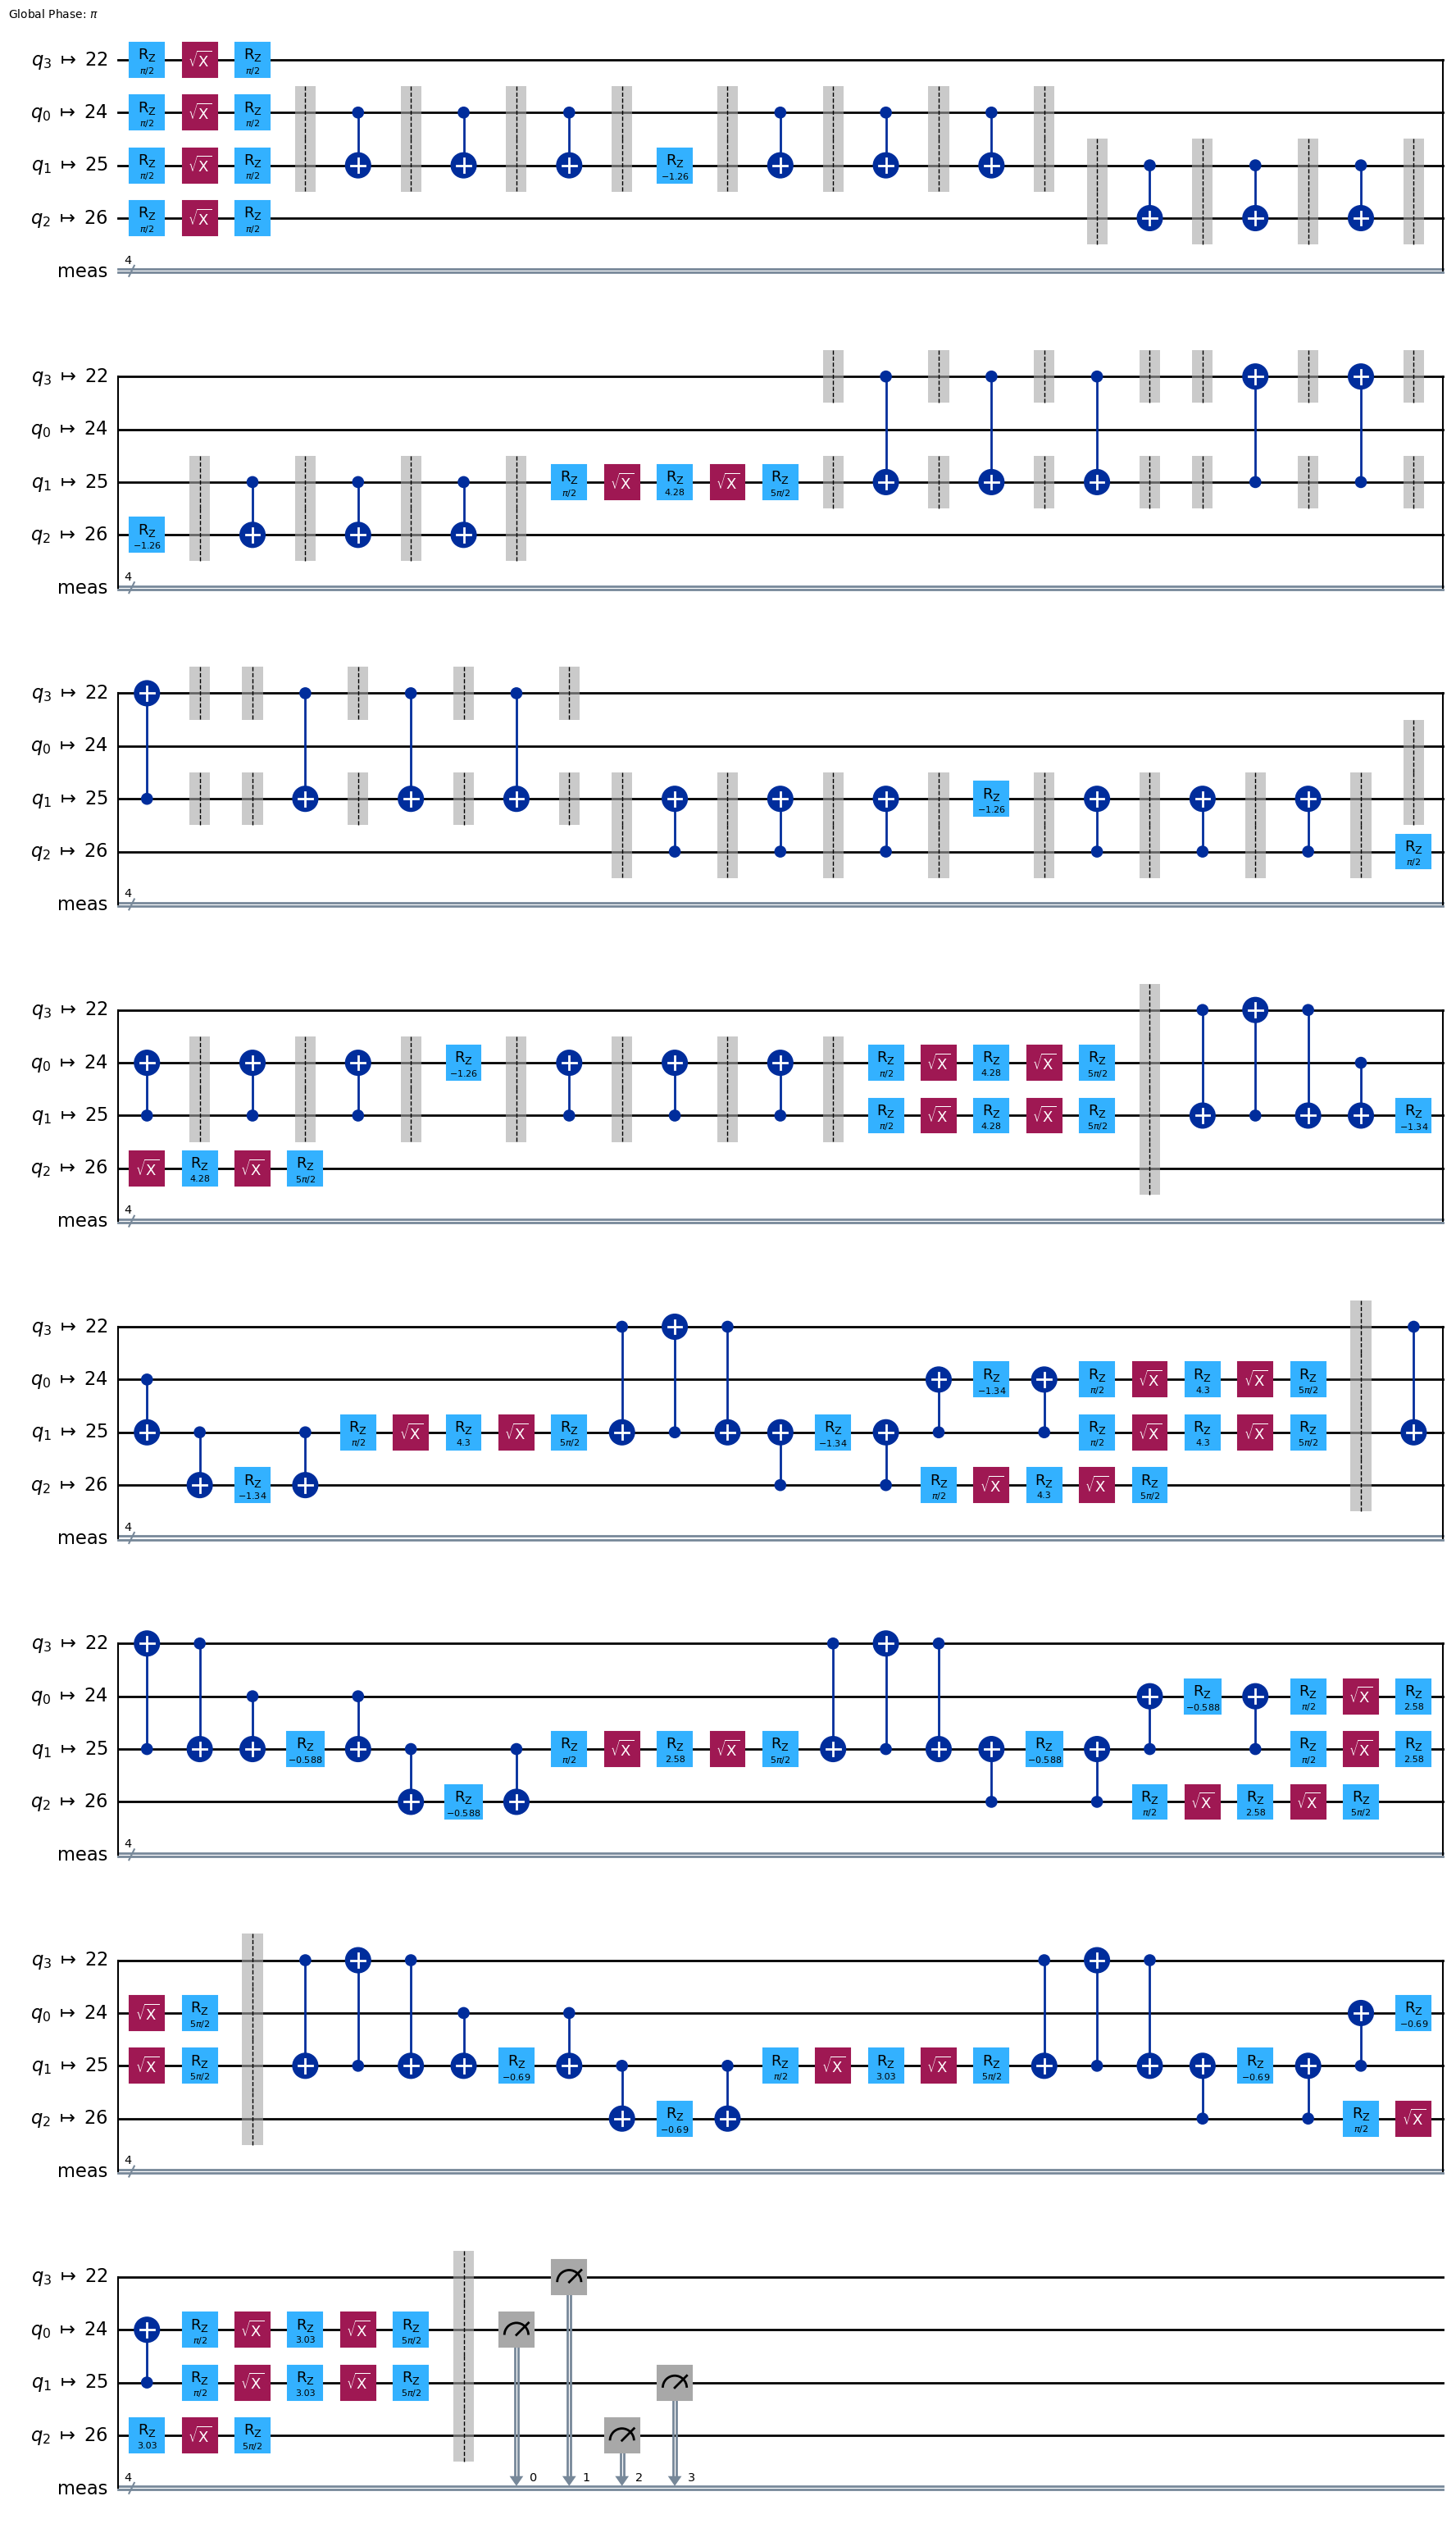

In [110]:
amplified_circuit2 = amplifier.amplify_circuit_noise(trans_circuit, noise_factor=1.4)
amplified_circuit2.draw('mpl', idle_wires=False)

In [111]:
amplified_job2 = noisy_estimator.run([(amplified_circuit2, isa_observables)])

In [112]:
amplified_result2 = amplified_job2.result()[0]
amplified_expval2 = sum(amplified_result2.data.evs)

In [113]:
amplified_expval2

-1.9267578125

#### Plotting the noisy expectation values

In [114]:
nf = [1, 1.2, 1.4]
expvals = [noisy_expval, amplified_expval, amplified_expval2]

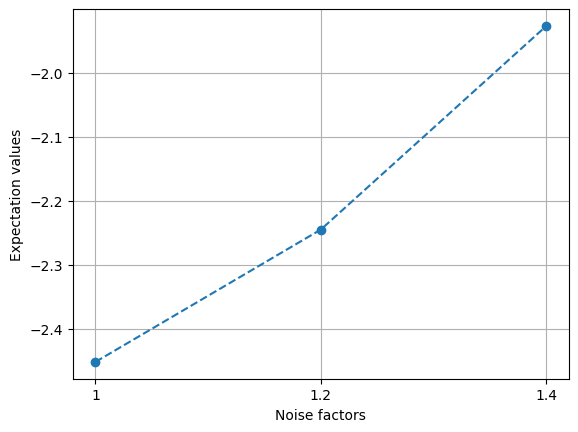

In [115]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(nf, expvals, 'o--')
plt.xticks([1,1.2,1.4],['1', '1.2', '1.4'])
plt.grid()
plt.ylabel('Expectation values')
plt.xlabel('Noise factors')
plt.show()

#### Extrapolate to zero

In [116]:
from zne.extrapolation import LinearExtrapolator

extrapolator = LinearExtrapolator()

In [117]:
extrapolated_expval = extrapolator.extrapolate_zero(nf, expvals).value

In [118]:
extrapolated_expval

-3.7841796897005144

#### Plot the result

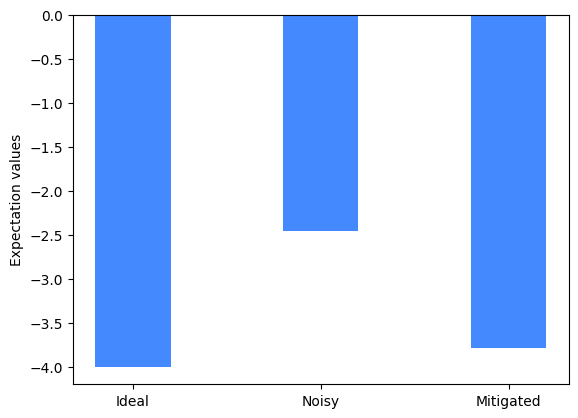

In [119]:
plt.bar(['Ideal', 'Noisy', 'Mitigated'], [ideal_expval, noisy_expval, extrapolated_expval], color ='#4589ff', width = 0.4)
plt.ylabel('Expectation values')
plt.show()

#### Cutting through the noise at a scale beyond classical brute force simulation

A noisy quantum computer is able to produce accurate expectation values on 127 qubits (https://www.nature.com/articles/s41586-023-06096-3)

<div>
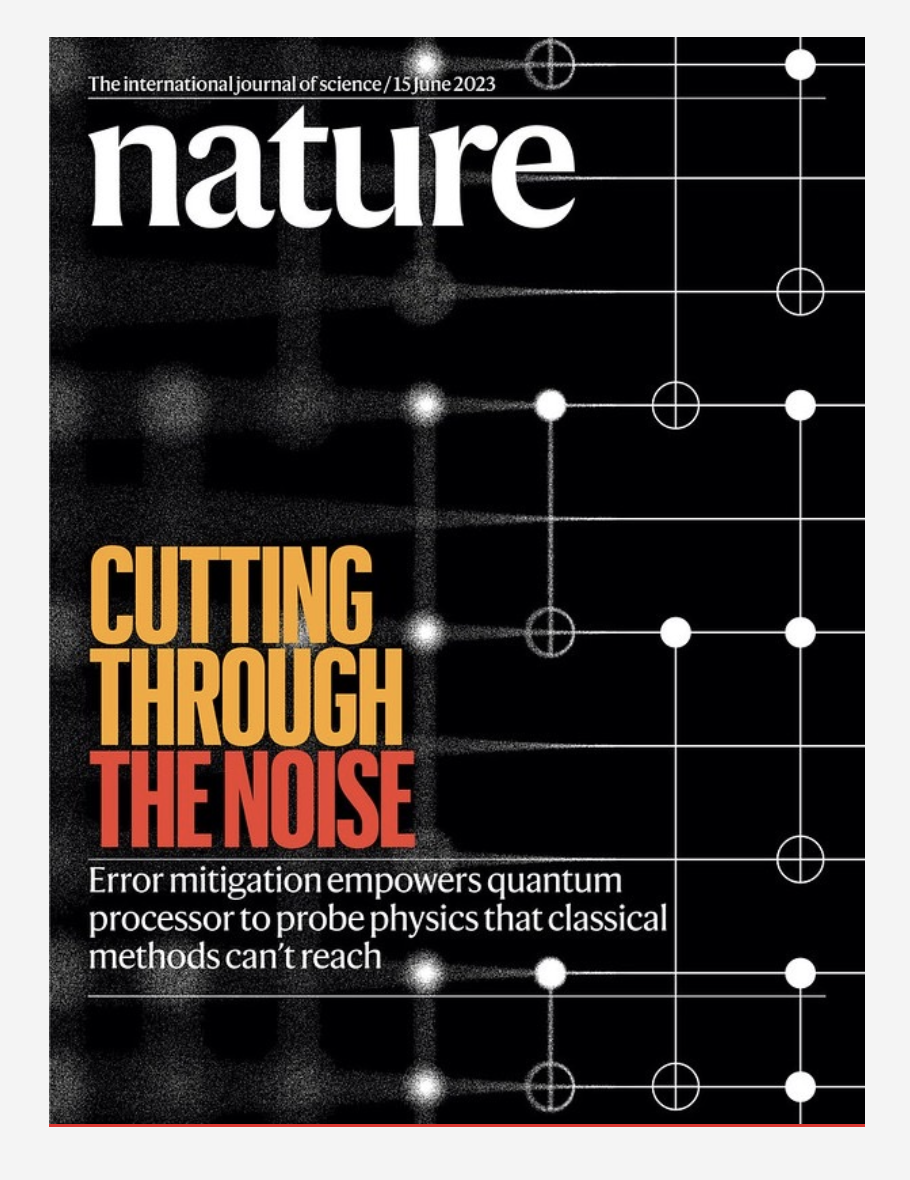
</div>

### Using Qiskit Primitives

In [120]:
estimator = EstimatorV2(backend=backend)
estimator.options.default_shots = 10000
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = [1,1.2,1.4]
estimator.options.resilience.zne.extrapolator = 'linear'

`estimator.run([(trans_circuit, isa_observables)])`

In [121]:
import qiskit_ibm_runtime
import qiskit

print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")
print(f"qiskit version {qiskit.version.get_version_info()}")

qiskit runtime version 0.23.0
qiskit version 1.0.2
